In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = "../data/processed/"

In [ ]:
import seaborn as sns
import pandas as pd

sns.set_style({
    'axes.facecolor': 'white',
    'axes.edgecolor': '.05',
    'axes.grid': True,
    'axes.axisbelow': True,
    'axes.labelcolor': '.0',
    'figure.facecolor': 'white',
    'grid.color': '.75',
    'grid.linestyle': '-',
    'text.color': '.15',
    'xtick.color': '.05',
    'ytick.color': '.05',
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'patch.edgecolor': 'w',
    'patch.force_edgecolor': True,
    'font.family': ['sans-serif'],
    'font.sans-serif': ['Arial', 'Helvetica Neue', 'sans-serif'],
    'xtick.bottom': False,
    'xtick.top': False,
    'ytick.left': False,
    'ytick.right': False,
    'axes.spines.left': False,
    'axes.spines.bottom': True,
    'axes.spines.right': False,
    'axes.spines.top': False
})
sns.set_context("talk")
palette = sns.color_palette([
  "#B48EAD",
  "#BE503E",
  #"#8FBCBB",
  #"#7bb292",
  #"#d7ae38",
  #"#628b97"
])

In [ ]:
runs_sampled = (
	pd.read_csv("../data/processed/aggregated/evaluated-sampled.csv")
	.groupby([
		"collection",
		"model",
		"sampler",
		"sample_rate",
		"aggregator",
		"i"
	])
	.mean()
	.drop("query", axis=1)
	.reset_index()
)

runs_full = (
	pd.read_csv("../data/processed/aggregated/evaluated-full.csv")
	.groupby([
		"collection",
		"model",
		"aggregator",
	])
	.mean()
	.drop("query", axis=1)
	.reset_index()
)

runs_baseline = (
	pd.read_csv("../data/processed/aggregated/evaluated-baselines.csv")
	.groupby([
		"collection",
		"model"
	])
	.mean()
	.reset_index()
)

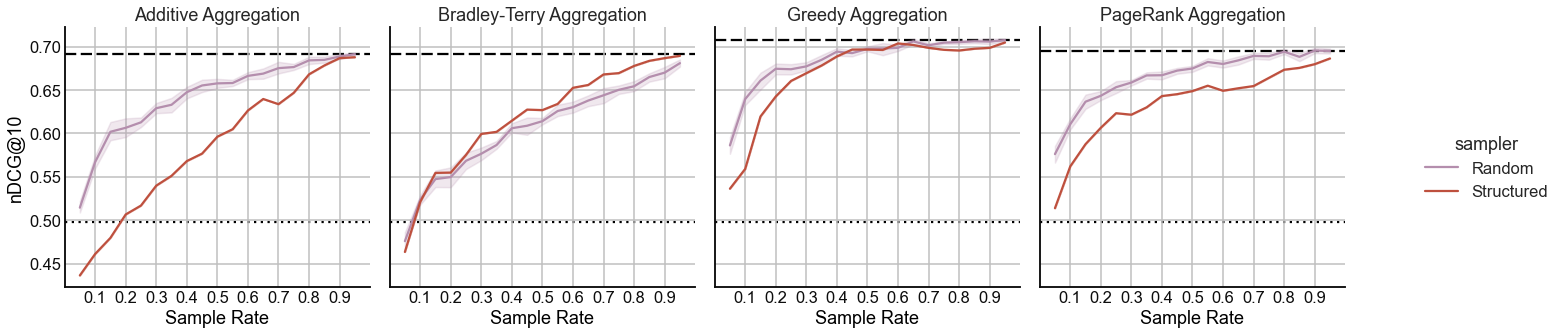

In [2]:

for collection in runs_sampled.collection.unique():
	for model in runs_sampled.model.unique():
		g = (
			sns.relplot(
				data=runs_sampled[(runs_sampled.collection == collection) & (runs_sampled.model == model)],
				x = "sample_rate",
				y = "NDCG_10",
				hue = "sampler",
				col = "aggregator",
				kind="line",
				palette = palette,
				facet_kws={"margin_titles": True, "sharex": True, "sharey": True},
			)
		)


		for col_val, ax in g.axes_dict.items():
			v = runs_full.loc[
				(runs_full["aggregator"] == col_val) &
		        (runs_full["collection"] == collection) &
                (runs_full["model"] == model),
				"NDCG_10"
			]
			v = v.values[0]
			ax.axhline(y=v, color="k", dashes=(5, 2), zorder=0)


			u = runs_baseline.loc[
			    (runs_baseline["collection"] == collection) &
			    (runs_baseline["model"] == model),
				"NDCG_10"
			]
			u = u.values[0]
			ax.axhline(y=u, color="k", dashes=(1, 2), zorder=0)

		(
			g
			.set(
				xlim=(0, 1),
				#ylim=(0.35, 0.75),
				xticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,  0.8, 0.9],
				#yticks=[0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
			)
		    .set_axis_labels("Sample Rate", "nDCG@10")
		    .set_titles(col_template="{col_name} Aggregation")
		    .tight_layout()#w_pad=1)
		)
		sns.despine()

		g.savefig(f"../reports/figures/{collection}-{model}.pdf")

In [28]:
gridsearch_data = (
	pd.read_csv("../data/processed/aggregated/evaluated-gridsearch.csv")
	.rename({
		"sample_rate": "window_size",
		"aggregator": "window_skip",
		"sampler": "aggregator"
	}, axis=1)
).assign(sampler="Optimized")

gridsearch_data.aggregator = gridsearch_data.aggregator.replace({
	"bradleyterry": "Bradley-Terry",
	"additive": "Additive",
	"greedy": "Greedy",
	"pagerank": "PageRank"
})

gridsearch_data = (
	pd.merge(
		(
			gridsearch_data
			.loc[
				gridsearch_data.collection == "dl-passages",
				["sampler", "aggregator", "window_size", "window_skip", "query", "NDCG_10"]
			]
			.groupby(
				["sampler", "aggregator", "window_size", "window_skip"]
			)
			.mean()
			.drop("query", axis=1)
			.sort_values(["window_size", "sampler", "aggregator", "NDCG_10"], ascending=False)
			.reset_index()
			.groupby(["window_size", "sampler", "aggregator"])
			.head(1)
			.drop("NDCG_10", axis=1)
		),
	    (
			gridsearch_data
			.loc[
				gridsearch_data["collection"] == "dl-passages",
				["sampler", "aggregator", "window_size", "window_skip", "query", "NDCG_10"]
			]
		),
		how = "left",
		on = ["window_size", "sampler", "aggregator", "window_skip"]
	)
	.assign(sample_rate=lambda df: (
		df["window_size"]
		.astype(int)
		.apply(lambda v: (50 * v) / (50 * (50-1)))
		.apply(lambda s: s*20)
		.round()
		.astype(int)
		.apply(lambda s: s / 20)
	))
	.assign(keep=lambda df: df["window_size"].isin(
		df
		.loc[
			:,
			["window_size", "sample_rate"]
		]
		.groupby("sample_rate")
		.max()
		["window_size"]
		.values
		.tolist()
	))
	.drop(["window_skip", "window_size"], axis=1)
)

gridsearch_data = gridsearch_data.loc[
	gridsearch_data.keep &
	(gridsearch_data.sample_rate != 1.0) &
    (gridsearch_data.sample_rate != 0.0),
	[ 'sampler', 'sample_rate', 'aggregator', 'query', 'NDCG_10']
]

gridsearch_data = (
	gridsearch_data
	.groupby(["sampler", "sample_rate", "aggregator"])
	.mean()
	.drop("query", axis=1)
	.assign(collection="dl-passages", model="3b", i=1)
	.reset_index()
)

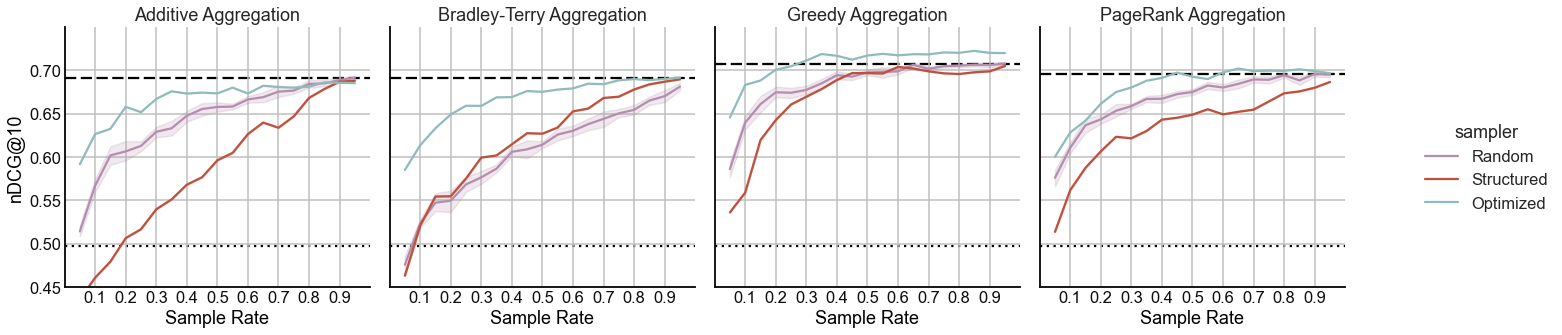

In [31]:
g = (
	sns.relplot(
		data=pd.concat([
			runs_sampled.loc[
				runs_sampled.collection == "dl-passages",
				["collection", "model", "sampler", "sample_rate", "aggregator", "i", "NDCG_10"]
			],
			gridsearch_data.loc[
				:,
				["collection", "model", "sampler", "sample_rate", "aggregator", "i", "NDCG_10"]
			],
		]).reset_index(drop=True),
		x = "sample_rate",
		y = "NDCG_10",
		hue = "sampler",
		col = "aggregator",
		kind="line",
		palette = sns.color_palette([
		  "#B48EAD",
		  "#BE503E",
		  "#8FBCBB",
		  #"#7bb292",
		  #"#d7ae38",
		  #"#628b97"
		]),
		facet_kws={"margin_titles": True, "sharex": True, "sharey": True},
	)
)

for col_val, ax in g.axes_dict.items():
	v = runs_full.loc[
		(runs_full["aggregator"] == col_val) &
        (runs_full["collection"] == "dl-passages") &
        (runs_full["model"] == "3b"),
		"NDCG_10"
	]
	v = v.values[0]
	ax.axhline(y=v, color="k", dashes=(5, 2), zorder=0)


	u = runs_baseline.loc[
	    (runs_baseline["collection"] == "dl-passages") &
	    (runs_baseline["model"] == "3b"),
		"NDCG_10"
	]
	u = u.values[0]
	ax.axhline(y=u, color="k", dashes=(1, 2), zorder=0)

(
	g
	.set(
		xlim=(0, 1),
		ylim=(0.45, 0.75),
		xticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,  0.8, 0.9],
		yticks=[0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
	)
    .set_axis_labels("Sample Rate", "nDCG@10")
    .set_titles(col_template="{col_name} Aggregation")
    .tight_layout()#w_pad=1)
)


g.savefig("../reports/figures/gridsearch.pdf")